In [1]:
include("../../src/WaterLily.jl")
WaterLily = Main.WaterLily;
using Plots; gr()
using StaticArrays
using JLD
using Images
using FFTW
using Statistics
using Interpolations
using DelimitedFiles
using PyPlot
using GLMakie
GLMakie.activate!()
using GRUtils

In [2]:
Lp = 128
N = (Lp, Lp, Lp)

(128, 128, 128)

In [3]:
inside(a::AbstractArray) = CartesianIndices(map(ax->first(ax)+1:last(ax)-1,axes(a)))
@inline CI(a...) = CartesianIndex(a...)
"""
    δ(i,N::Int)
    δ(i,I::CartesianIndex{N}) where {N}

Return a CartesianIndex of dimension `N` which is one at index `i` and zero elsewhere.
"""
δ(i,::Val{N}) where N = CI(ntuple(j -> j==i ? 1 : 0, N))
δ(i,I::CartesianIndex{N}) where N = δ(i, Val{N}())
@inline ∂(a,I::CartesianIndex{d},f::AbstractArray{T,d}) where {T,d} = @inbounds f[I]-f[I-δ(a,I)]
@inline ∂(a,I::CartesianIndex{m},u::AbstractArray{T,n}) where {T,n,m} = @inbounds u[I+δ(a,I),a]-u[I,a]
@fastmath @inline function divv(I::CartesianIndex{m},u) where {m}
    init=zero(eltype(u))
    for i in 1:m
     init += @inbounds ∂(i,I,u)
    end
    return init
end

divv (generic function with 1 method)

In [4]:
function project!(a,b)
    dt = a.Δt[end]
    for I∈inside(b.z)
        b.z[I] = divv(I,a.u) # divergence source term
    end
    rr=WaterLily.solver!(b,tol=1e-3,itmx=1000,log=true)
    for i ∈ 1:3  # apply pressure solution b.x
        for I∈inside(b.z) 
            a.u[I,i] -= b.L[I,i]*∂(i,I,b.x)
        end
    end
    return rr
end

project! (generic function with 1 method)

In [5]:
sim = WaterLily.Simulation(N, (0, 0, 0), Lp; U=1, ν=0.0,T=Float32,mem=Array,perdir=(1,2,3), Δt=0.00001)

xList = reshape((1:N[1]+2).-2,(N[1]+2,1,1))/N[1]
yList = reshape((1:N[2]+2).-2,(1,N[2]+2,1))/N[2]
zList = reshape((1:N[3]+2).-2,(1,1,N[3]+2))/N[3]


function leVeque!(u,x,y,z)
    u[:,:,:,1] = @. 2*sin( pi*x)^2*sin(2pi*y)  *sin(2pi*z)  *N[1]
    u[:,:,:,2] = @.  -sin(2pi*x)  *sin( pi*y)^2*sin(2pi*z)  *N[2]
    u[:,:,:,3] = @.  -sin(2pi*x)  *sin(2pi*y)  *sin( pi*z)^2*N[3]
    # u[:,:,:,1] .= 2
    # u[:,:,:,2] .= 1
    # u[:,:,:,3] .= 1
end

leVeque!(sim.flow.u,xList,yList,zList);

In [6]:
rr=project!(sim.flow,sim.pois)
WaterLily.BCVecPerNeu!(sim.flow.u;Dirichlet=true, A=sim.flow.U, perdir=sim.flow.perdir)
save("aLeVequeubase.jld","data",sim.flow.u)

In [7]:
u⁰ = sim.flow.u
Statistics.mean(abs.(
    u⁰[3:end, 2:end-1, 2:end-1,1]-u⁰[2:end-1, 2:end-1, 2:end-1,1]+
    u⁰[2:end-1, 3:end, 2:end-1,2]-u⁰[2:end-1, 2:end-1, 2:end-1,2]+
    u⁰[2:end-1, 2:end-1, 3:end,3]-u⁰[2:end-1, 2:end-1, 2:end-1,3]
))/N[1]


4.2499863f-8

In [8]:
u⁰Mag = sqrt.(sum(u⁰.^2,dims=[4]))[:,:,:,1];

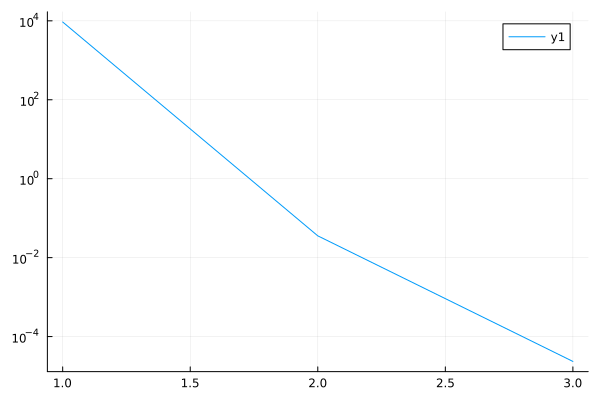

In [9]:
Plots.plot(rr,yscale=:log10)

In [10]:
figures = Vector{GRUtils.Figure}(undef,181)
for d ∈ 0:180
    figures[d+1] = GRUtils.isosurface(u⁰Mag*(sind(d)+1),N[1])
end
GRUtils.video(figures, "mp4")

GR.HTML("<video autoplay controls><source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAA+m5tZGF0AAACsQYF//+t3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xOCBsb29rYWhlYWRfdGhyZWFkcz0zIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjQgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1hYnIgbWJ0cmVlPTEgYml0cmF0ZT00MDAwIHJhdGV0b2w9MS4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAABlgWWIhAAa//731LfMsu1Tb7YLqPeiniZfQ3UlAZuWxO06gAAAAwAAAwAAAwAETe7vTlRfmUOWUAAAAwAxIAUEAvb0Q/gcL0le5xU+tgha5D+t60NiRIHWdS/LR/+WyE6Y1vTsCveOj7/g3JtfH54Vgn9N99PQXAUOi85Gx1K8W57B2NV+aMPkEMaevobCNFtMmI0wQbOF++z4C+8Tfv4m9DYJqDX6lgy4RAnwINIritRRl/5sDlzsy6px/Z1nYTr0mgEe1t5/0prqdZaeuRP+gjLF2QQ/4prnwVBu5WuILqzY+koVEg+lfcRp4290QIpVNCYhPjUlure5WuaHOf7oxUV5vY2N6hjLQk2AkT8HimmyEueMcE2m6S4QEH2XScGsHFVU+XJz9P3vcLXMKCT0LDuWGr0jNBtTNJSlfW0/CHWHeby9beV+pyu1hpOtP/4fdJ8oPVOej+lIgRjmDgwVA65TGuBNiDQxsb2N3M2xLnj/Agndcq/keUq4sQguyRhd7cr4AMNnnyrQIokNYXCdL1XaNN8Is3RgB0ZxZdpDzDcW8zHowwWj+ent/7XoV+2qzKM3pz3jPd72QaMXRgz9/KX3IMH+hYuaHhl64rIhJA1Ew8s1CeZu4O/uLrE+e6mue4u3NzQr9BSwGup6siuhlKcOZ6oKtz1MNbmVNPeSmblI8Lcvk1If1Vi1qSD/+T6kOJ24ejLM3QCcThDA15G2Ph+w/reSejAUU//akO2aW+6cxcTo1M9g3ozi23hSiYuxAGyT4RvxUm8F2rSQRJtZqt8oIFOysUMbvWx1Vtn8z2UXwQRPIHEtLS5qmk+Mu5k+YZpDpBcrB1FUWQVvwj9L0chr3+vwqxmA0J4JKVCyxiSIR4ZWJPHSccXWcodXt0wav6hxHAAM8x9gbKpMCzjmGBLYkhJZ0ze+Lid9BP/3Du9WVx88U3/rXA/RH25BrMsKbgm0/9IjsYZ3trCRDTyegx8ciggm/8ZfaFrHrFErbaVwW3ytJC9V2533yHK62SAVvP8nG1cPAB9jp+d8g1uYj73KHCB3ENR7FjxC7IxQxZf4ObL3Nj8m2JNrzMBLBm+eHZArVB4tKUWWFvYtX5T8BuM2FuXZCUixq0b9IF8j5SEOY9tkIZdLR2m8ufr/JP+tcLRXBphL2fMkk8i7YcJHTFB60d0q/N3zGx9Qj11XZwxYwthgaVDPzwLJbu9sB8AYnwj9nNmXndWTI4G/6yk96bIjSSZHrNbZKa9lMNlVhvnb2a3YWKxlhE7GPzM6hgT36opoPpSxZ6YBlHE8tgY+Su6PmXiLyooKrTJhsMKatJYQrifCTdrSx931OABmbuaSZaTUanf5Z7R84yOoalvg+mkhd5BK3EVi5VlBaHN2ixg8a3Gn/+mO5PDOioATVcJFudqj8gDDiamMx4asI7A2vzxPaHKe2xuoJA4ppRVA/GVd69IPnClUZeBT4ndTzI+GZ7SdFBo2dcpTbh/oG6WY815WEzDjd05VLvY1CvF8ZsFSx703iCYg8nXdp9EY7mMp1T/awJcktCAwq7R0I2aZliHWd4t2hYW/DfgABL9N6il1YDbsPIuNoeCLdRWMF5wEqEi9T7Hg6otqW8NLtkjX4xoioTd29uEO8nH/e5o/kfOo2s9Fbs8x+6l3G7PsRrCA09A4ecgWEsX0mEOuL4i2neQ3YbXqQ0QnFezCqSjnOBmYQ1t4xyg36fWYLLleDSV4vVhyqkZAEL0xMOdL+nTFAryY1aLfUsODSJ3L7bKQY1IXkvqz50PTQ9H22qsAAZbd2i0R+GX251O68KFgeBZaBhLjdrRNrqy9wzaKQQuLKgaKYFpSJvxSwqW/QAFdk2CeR9TxGtz7nu+C3NBNAHIkQgsetk4y5YOD3NvSRungko+I5KtDH8UmhFvvf/8z/TduaKfRER1dm91jRuYAODUnjts/ayG8Li9b7yfes8OBrB/oC/gLP2p5+ivDL6XLtfGLYWSfqdL38fe5QzCrCQ9D2w8iG13ZpBmcJ0v8wlEmkCA8vBleiB9NNz26TG+act5kWOd+UYSvALWLFf3gT8D1xMFjmvwZIuW4RAGMtf8xSFx7/7wK3n2rlFbDlYMaxdBvnQTEoma4e7Zl1U6BDlXdM0A0sgB11Vp9cKpHtJcvEcbsfWoxi1ArUZ+qlyCCPc8TO+G41+/IIKslNK2C0pKOrCQuD4YYc1APrWgEumsECRR+97XSIxrzOf1IfY0LCYagRjey10Paq1bWCV4AHnyZO6fg1aHL9zAoBZTBsfquTsoR8TKoLV3yBHCdmt2KWu/x0XeX8CN6VmRkUMaPkMjYFMiikGfBVzXQnDnrEGo5xnyxvPwcSzmgvAADog+Qi02QMYAv38Kw7Wym/0l7DP1d3lU1fmhSz3H5KcgvnQua2EuYKX0E6CpHPnnYXRYPAt/Km7noiYbzavSh5zBidf282Thk9etxngiemu3JfXNQdEQCw6ZNsRX3R81M8Qcus2B8Owa3COetQ8bLlOBjVj8FqUYhOk1fUbTAHYtVDPfpCmx7iU1l9SK/+lHAtAOU9qouDX1p/PBxAd2jLtqjqX0tyKBL8sj4PQoAtiXgmzSykx5hF5lQ52nHNE34NmNfLJGm9lVLJ7If7xMDero5wD77lZSbxhuRRpwX3ISRtVV5e6lQnn/b7/nCqyWiTiaV7ATcrGjR9a5U727NJKQr78i1X40/sRtku8H51L6AB83GWsW/GXby0zTYjCgjwVvWIfMy89FN5zAaBhTP0olaBwIqpFfySGB3P5zZeW6lt5p+M52wKa8IN2vPpywrg7XJP1CFZt36dmpWaJHaqUSX8fCA+XiA/zn7D3ej/8HXS04RLqF1TMcotR9Dd/H1Ah3EGHHCR8qsZlqZ50bqM+6PCgWFTcukfVyWReYhYHk640U

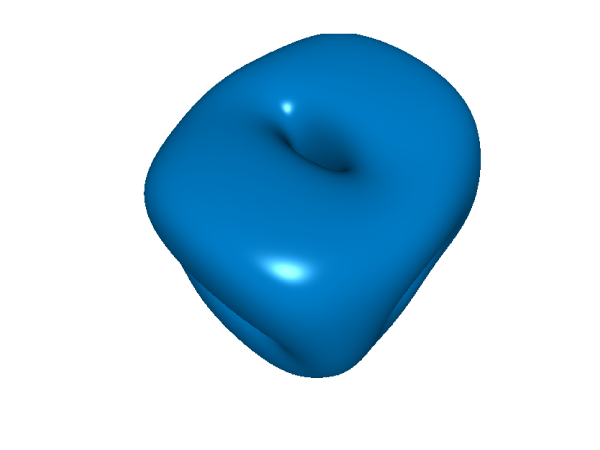

In [11]:
GRUtils.isosurface(u⁰Mag*(sind(90)+1),N[1])

In [12]:
# Make a plot with example data
x = LinRange(0, 800, 100)
y = sind.(x)
GRUtils.plot(x,y)
# Make a video sliding over the X axis
GRUtils.video("mp4") do
  for d = 0:10:440
    GRUtils.xlim(d, d+360)
    GRUtils.draw(GRUtils.gcf())
  end
end

GR.HTML("<video autoplay controls><source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAFfxFtZGF0AAACsQYF//+t3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xOCBsb29rYWhlYWRfdGhyZWFkcz0zIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjQgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD00MCByYz1hYnIgbWJ0cmVlPTEgYml0cmF0ZT00MDAwIHJhdGV0b2w9MS4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAA4+mWIhAAY//73ye/AputbW7W/k89I/Cy3PsIqP25bE7TqAAADAAADAAADAAARNyNtK8F+ZQ5ZQAAAAwDHqs+apxnI+ADz4WV4YxOF47TE7PFpLdyq9ntyajYF2gbLHyX/2oFBo0JvvyaYluSypVxCqvHytULMUyJ6JUCB80BqtHZEnRaHHvkOTE3KL2H046iVr6f4TmSC1C4MD8daczBCibwSMAp9FB2jtQJGJLVICNchcXiWddnyCXB7+eAQTjVuOKx9ZHuYTapr4Kayf/3r6oEkV/GLZLY2YGnXHsESqQN9njmRNRYB1fh7Ls5/ny7GVFVfIryUkqgxsiZAsfdiiJYZfifQHiMGtvnS1OOyEPOR0MjbvrLOlTyOWQVgPH77sZMMn5gAAyRQpmBPMU/Zbms8H0J7Dr8XFd0meZdsUv0+lkjgyzqm2yvzMfE90qZVxIHm1We5ZiNJoyL8M3DR07iT+wZT0edH7YB9WMtWCedhd28Ky6VaxwhIyPBjCuQdb8HdEuQnXxxFAgt9Y7yy2t240KzJfyA5jBGeS7GP2k/PzugvL495UzTau+kMJX4RkNCAACT8CL0TaLJ888m0YWiWkoZQoc1ukTPb80f4ydfdJ0WmH+72QgU+tPrnKF/klFXf5vKuin3JFReY/CtSZ/gvX2i14Fk8s7mJalQhpXBUqWKO7zyQGNYQa22ES/rYxz0hZ2vV40+z/fLipTWen/LTn8rxrCxNvacxsJ5F7jR5Tv00I9SedKDB83anLIQerQm4tBK8hPwSlUHBC6ktRoZXMzOKYP1GFIQjXBXyBHaeM5YzgmSfE1+Yl1lU0OLCu/EREAmz8Ei+5DlsSgeUmwrrgiRyTKbxekpnFC9o3JF7DdivxaIORYTJ57C503M5ikjAuk1t6U3rHQyFhdo4ZkLgY+fgqNihhHJx6bAQxugHcSC8bTsc3KWO/9r/stfzsxeUQUBqAqJZS98Bo29SwtwW+YfXaPYzubeRRYJ6Gki6dGVcrRi/TuNi2d+bt6T+SR2hq7N1yeCVXX869vKzyt6wXkb9r4U9or2J5AkbzDOxN95fhmUKepF8zIjZQtZCoyNq9Ez8zB7LF33E3XfsKFmdXcg5g+NCgTTveqBHqGTP98RHxKbcux5OQqO5qVu2Tn09wxlC73ZHXKPR6u4cWHPIyp/xJ7i5dMSdIVCIJJNa0hw19p77J86S8ZUj6WuAka2MxNTNXGHaQ+jPoVrJUbP6toVknut+VFr92/v2KDx2t/Z3k+gtWfkbzWXpvvuU+nHVoUyJCXxzyq6mSq6WmNQM4ASzNMg0gbMpSVGiHR2LNs1V/bwRg77YZ/XckSDbiVUY/Lb/nPMNY0RX/9LdpekCjwv7c7CdUiHf4lv/Z+KGh/JbF2QWOasyU8Ob3YXqnFGwjAK+YAOyXkkgWSlsTkBq904d3OB/GcbKDuifLCvigG43izRbzDQV0q7kW3Ioz4BTNrfNltFLVhGnBTnykve1d2Me7GhwN9Jz/dngtrjwG8WaqlLjtd3JJUdwDuzy8XLKeVtyPvCKW9Ndjc5FyYmJpo662DF6O6IsPKldUgIupARb1dm/8SfBiVl+pyq6s1NDrLEPEPSi6gueXbWQLbDK9IAodr1TWfMnQDpHx7xxq9tt+T2lY/4PKzq7eC0KCO9cSi0xpTVA9OVzBlmGjKMjfglWj2D5SU0ElEsvPPIF33B9ARFIQ5/ByrwnsQ8gJoMkQMlmY4dkAl6Mnogd9EFSqK4VTw48Kn9uhJ1RUHtWxYFPhq0Yjeytt7uigC7GS3Y+HU4fdckZyeDQxmo9U7ADOMorObbxhRZwoB/EnwOSE6sMIRlsUg6tGRaSfiQ5plhNPVd3N5IiirZUoLjRtMWq3fjSwciaH/wXqqM1NfqdTQjWWFwAZxbTwsMXMw8p/dQJe5eBOHbKxocGAWocaixQ4jp2BEeHeyBvEWHbZadyyOSVSrJ8z2SbC4sbT01Idio0ZrqFDBf3AgboiUdALWJ5cJn75KMmwzsZwb42mFrv/22Ihz8lLhhY9ZeJovyxJh91u0IfljMaWkmN0AuOt3Q35plRxuh/v5pIcB0iMUA8UNCKoLZUSrc/6qwsn7HSB6qgZpsoBgiI8Xn7O1r/ERvE2FRhvf0bKORX2MJJd85UXf4Dp33ug/JEO+PeV33UsLgALA4N71kMPLK9TnDMoIu6d4+EMBwSGL7kWCNeJwcixZ/v7p/XDtSQ7M94+NnufWRpKcjjPQr+t141izwL0UOYg2pji/ASwCKgxlhP38TUBeconHgeZnnPxCWQqJk3FW33IOG26Yadcq29G/i90ultu6AnVBFdAW04s5FteLCLdlzkyVSK/9QC2Wn+EzcHwnoeGgUHN0u8t11DNupS8wfwsvgMGx3z6GOuoKNwg++5A8ifd5TxeAuLFhmK+rl54E2TAG+idPUP+UmMYrm3qJbduls2T4idO8vMlFkXlDanMzDU5CwEBeJrBMIDSL5Ak8YfqFXInIXEZlpG2ZDenzrg/54/l6GP7VhqosM+mPDM3U7Dgmt35k1ncOjoCEorC1Cv9YaB/pp18347maATKcAgGNDXzY/0XS9HTcjLL++zsIWZ8fH9TAAVlLDOvRMjZzGOwfSQtvC/vwTJF3QTn1CiRVk+lUQXXQa8nKBIYJ8SjTAukVwQWCtkW+tsle4j/BAZ/XB8y+4VMaXSnHhVlwIg/3kAqF7ydqZE9M5Kk76+40Eu/s4kcowFZq5A8p2SI3jXY7kfqpXwipORZyByewY0CgNVuurBSExZvFQl3SArMXWKeIjP/i4IVIexby8D4FLKnDDytFF5eshtiyDa7dPWuG5PS8GQDsqyyrvyW61eeSAjjs1rweFfziIpE0MEFt2ZK0+/Cfqcmcbgo0YXPNTPVSfRjEp2O77saft

In [13]:
sind(90)+1

2.0

In [14]:
uu = copy(sim.flow.u);
leVeque!(sim.flow.u,xList,yList,zList);
uuMag = sqrt.(sum(uu.^2,dims=[4]))[:,:,:,1];

In [15]:
GLMakie.contour(uuMag,levels=[N[1]],alpha=1,isorange=N[1]/10)


In [16]:
uDiffMag = sqrt.(sum((sim.flow.u .- uu).^2,dims=[4]))[:,:,:,1];

In [17]:
maximum(uDiffMag)

1.2820318f0